In [2]:
import torch
import torch.nn as nn   
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


from configurations import load_data, make_data_paths, save_fig, create_fig, set_font_sizes, apply_general_styles, make_params_dict
from configurations.plot_config import FONTSIZES
# from sam.small_models import InductionHeadAttention, warm_initialization, interpolation_initialization
from sam.small_models import noisy_initialization , Lin_Sfm_Attention
from sam.dataset import get_sample_permut, get_dataloader
from sam.evaluation import evaluate_model ,evaluate_model_lin_sfm

from sam.small_models import InductionHeadAttention
from sam.dataset import get_sample_permut

apply_general_styles()

# Several runs learning


In [3]:
# Fix Parameters
vocab_size = 64 # Vocabulary size
seq_len = 64  # Sequence length
batch_size = 64 # Batch size
dataset_size = 5000 # Dataset size
train_fraction = 0.8 # Fraction of data used for training
beta_1 = 1.0  # Induction head beta_1 parameter
beta_2 = 1.0  # Induction head beta_2 parameter
beta_out = 1.0  # Induction head beta_out parameterex

# Variable Parameters
num_epochs = 1500 # Number of training epochs 
lr = 0.05 # Learning rate
cV = 1.0     # Coefficient for WV1  
alpha = 1.0 # Coefficient for interpolation 
opt = 'SAM' # Optimizer choice  =  'SGD' or 'adam' or 'SAM'
p_error = 0.0 # Probability of introducing noise in the target for the induction task
rho = 0.0 # Rho parameter for SAM optimizer
attn = 'linear' # Type of attention: linear or softmax
loss = 'MSE'
experiment_name = 'optimizers'


configurations = [
    ('softmax','CE'),
    ('softmax','MSE'),
    ('linear','CE'),
    ('linear','MSE')
]

fix_names = ['vocab_size','seq_len','lr','num_epochs']
var_names = ['alpha','cV','opt','rho','p_error','attn','loss']


results = []

for (attn,loss) in configurations:    
    params = make_params_dict(fix_names, var_names)
    data = load_data('summary',experiment_name,params,show=False)
    results.append(data)

data.keys()

dict_keys(['model_step', 'global_step', 'train_loss', 'val_loss', 'val_accuracy', 'target_mass', 'epc_step', 'epc_model_step'])

Figure saved on /u/c/cerazova/SAM/plots/2026-02 as comparisson_learning_alpha1_cV1_lr0.05_num_epochs1500_optSAM_p_error0_seq_len64_vocab_size64.png


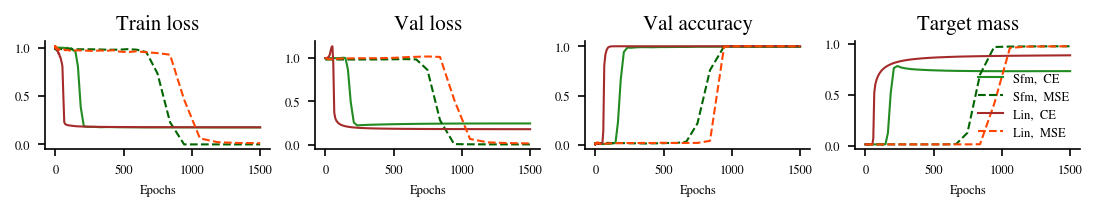

In [4]:
# Setting

labels = ['train_loss','val_loss','val_accuracy','target_mass']
ncols = len(labels)
colors = ['forestgreen','darkgreen','brown','orangered']
setting = dict(lw=1.,marker='',markersize=2,alpha=1.0)

set_font_sizes(conf='tight')


# Plot
fig , axes = create_fig(ncols=ncols,size='double',h=0.18)

for i , ax in enumerate(axes):
    ax.set_prop_cycle(color=colors)
    ax.set_title(labels[i].capitalize().replace('_',' '))
    ax.set_xlabel('Epochs',size=FONTSIZES['xs'])
    for j , (attn,loss) in enumerate(configurations):
        data = results[j]
        label='Sfm' + rf',  {loss.upper()}' if attn=='softmax' else 'Lin' + rf',  {loss.upper()}' if i == ncols-1 else None
        norm = np.log(vocab_size) if labels[i] in ['train_loss','val_loss'] and loss == 'CE' else 1.0
        setting['ls'] = '-' if loss == 'CE' else '--' 
        ax.plot(data['epc_step'],data[labels[i]]/norm,label=label,**setting)
    if i == ncols-1:
        ax.legend(fontsize=FONTSIZES['xs'],frameon=False)

# ax.set_xscale('log')
# for ax in axes[:2]:
#     ax.set_yscale('log')

names_plot = ['vocab_size','seq_len','lr','num_epochs','alpha','cV','opt','p_error']
params = make_params_dict(names_plot)
save_fig(fig, 'comparisson_learning',params=params,date=True)

# Several Runs Matrices

In [5]:
# Fix Parameters
vocab_size = 64 # Vocabulary size
seq_len = 64  # Sequence length
batch_size = 64 # Batch size
dataset_size = 5000 # Dataset size
train_fraction = 0.8 # Fraction of data used for training
beta_1 = 1.0  # Induction head beta_1 parameter
beta_2 = 1.0  # Induction head beta_2 parameter
beta_out = 1.0  # Induction head beta_out parameterex

# Variable Parameters
num_epochs = 1500 # Number of training epochs 
lr = 0.05 # Learning rate
cV = 1.0     # Coefficient for WV1  
alpha = 1.0 # Coefficient for interpolation 
opt = 'SAM' # Optimizer choice  =  'SGD' or 'adam' or 'SAM'
p_error = 0.0 # Probability of introducing noise in the target for the induction task
rho = 0.0 # Rho parameter for SAM optimizer
attn = 'linear' # Type of attention: linear or softmax
loss = 'MSE'
experiment_name = 'optimizers'


configurations = [
    ('softmax','CE'),
    ('softmax','MSE'),
    ('linear','CE'),
    ('linear','MSE')
]

fix_names = ['vocab_size','seq_len','lr','num_epochs']
var_names = ['alpha','cV','opt','rho','p_error','attn','loss']


results = []

for (attn,loss) in configurations:    
    params = make_params_dict(fix_names, var_names)
    data = load_data('summary',experiment_name,params,show=False)
    step = data['model_step'][-1]
    file_path , _, _ = make_data_paths(f'model_{step}', experiment_name, params=params,ext='pt',base_dir='../data') 
    model_state = torch.load(file_path)
    results.append(model_state)
    # print(model_state.keys())

# data.keys()
model_state.keys()


matrices = []
maxs =[-1e5]*len(results)
mins = [1e5]*len(results)
for r in results:
    WQ1 = r['WQ1.weight'].cpu().numpy()
    WK1 = r['WK1.weight'].cpu().numpy()
    WV1 = r['WV1.weight'].cpu().numpy()
    WQ2 = r['WQ2.weight'].cpu().numpy()
    WK2 = r['WK2.weight'].cpu().numpy()
    matrices.append((WQ1.T@WK1, WQ2.T@WK2, WQ2.T@WK2@WV1))
    for m in matrices[-1]:
        maxs[len(matrices)-1] = max(maxs[len(matrices)-1],m.max())
        mins[len(matrices)-1] = min(mins[len(matrices)-1],m.min())
    



Figure saved on /u/c/cerazova/SAM/plots/2026-02 as comparisson_matrices_alpha1_cV1_lr0.05_num_epochs1500_optSAM_p_error0_seq_len64_vocab_size64.png


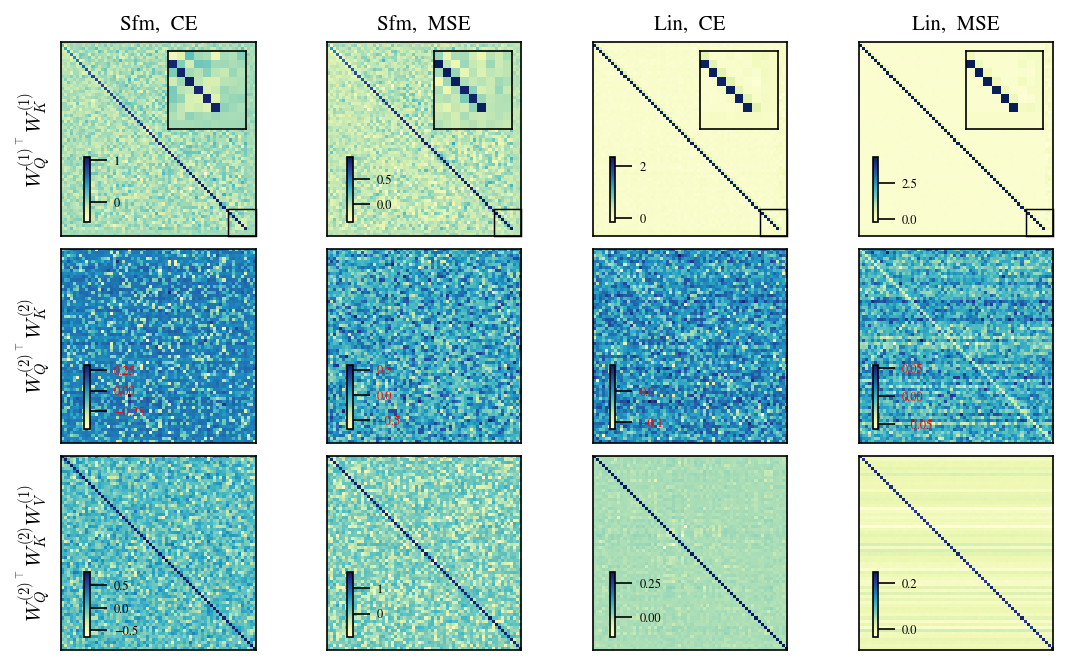

In [6]:
# Settings
titles = [r'$W_Q^{(1)^\top} W_K^{(1)}$',r'$W_Q^{(2)^\top} W_K^{(2)}$',r'$W_Q^{(2)^\top} W_K^{(2)} W_V^{(1)}$']
ncols = len(configurations)
nrows = len(titles)
cmap = 'YlGnBu'
V = vocab_size
# Make plots
fig , axes = create_fig(ncols=ncols,nrows=nrows,size='double',h=0.6)

for i , tit in enumerate(titles):
    for j , (attn,loss) in enumerate(configurations):
        ax = axes[i,j]
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.spines[['bottom','left','top','right']].set_visible(True)
        if j == 0 : ax.set_ylabel(tit)
        if i == 0 : ax.set_title('Sfm' + rf',  {loss.upper()}' if attn=='softmax' else 'Lin' + rf',  {loss.upper()}')
        M = matrices[j][i]
        ax.imshow(M,cmap=cmap)#,vmax=maxs[j],vmin=mins[j])

        condition = i == 0
        if condition:
            ax_in = ax.inset_axes([0.55, 0.55, 0.4, 0.4])  # [x0, y0, width, height]
            ax_in.spines[['bottom','left','top','right']].set_visible(True)
            ax_in.imshow(M,cmap=cmap)#,vmax=maxs[j],vmin=mins[j])
        
            ax_in.set_xlim(V-9.5,V-0.5)
            ax_in.set_ylim(V-0.5,V-9.5)
            ax_in.set_xticks([])
            ax_in.set_yticks([])
            
            inset_indicator = ax.indicate_inset_zoom(ax_in, edgecolor="black", alpha=1, lw=0.7)
            for connector in inset_indicator.connectors:
                connector.set_visible(False)
           

        # condition = i == nrows-1
        condition = True
        if condition:
            cbar_ax = fig.add_axes([np.linspace(0.07,0.8,ncols)[j], np.linspace(0.67,0.03,nrows)[i], 0.005, 0.1])  # [left, bottom, width, height]
            cbar = fig.colorbar(ax.images[0], cax=cbar_ax)
            # Make the colorbar ticks white
            cbar.ax.yaxis.set_tick_params(labelcolor='red' if i == 1 else 'k',size=FONTSIZES['s'])


names_plot = ['vocab_size','seq_len','lr','num_epochs','alpha','cV','opt','p_error']
params = make_params_dict(names_plot)
save_fig(fig, 'comparisson_matrices',params=params,date=True)

# Perturbation of Model

In [7]:
def create_perturbation(seq_len, vocab_size, device):
    # Create random perturbation of parameters
    names = ['WQ1', 'WK1', 'WV1', 'WQ2', 'WK2']
    shapes = [(seq_len, seq_len), (seq_len, seq_len), (vocab_size, vocab_size), (vocab_size, vocab_size), (vocab_size, vocab_size)]
    perturbations = {name: torch.randn(shape).to(device) for name, shape in zip(names, shapes)}
    # Normalize 
    for name in names:
        perturbations[name] = perturbations[name] / torch.norm(perturbations[name])
    return perturbations

def perturb_parameters(model, perturbations , epsilon, device, beta=1.0,normalize=False):
    # Make copy of model 
    new_model = Lin_Sfm_Attention(vocab_size=model.vocab_size, seq_len=model.seq_len,attn=model.attn).to(device)
    new_model.load_state_dict(model.state_dict())

    with torch.no_grad():
        for name, param in new_model.named_parameters():
            # Skip if betas , embedding or positions
            if 'beta' in name or 'embedding' in name or 'position' in name:
                continue
            name = name.split('.')[0]
            if name in perturbations:
                norm_param = torch.norm(param)
                param += epsilon * norm_param * perturbations[name]
                if normalize:
                    param /= torch.norm(param)
                    param *= norm_param
    
    # Set all betas to beta
    with torch.no_grad():
        for name, param in new_model.named_parameters():
            if 'beta' in name:
                param.fill_(beta)
    
    return new_model



def evaluate_perturbed_model(model, data_loader, perturbations , epsilons, device, loss_fn,loss_type, beta=1.0,normalize=False):
    
    results = {
        'loss':[],
        'accuracy':[],
        'target_mass':[]
    }
    for epsilon in epsilons:
        perturbed_model = perturb_parameters(model, perturbations , epsilon, device, beta=beta,normalize=normalize)
        loss , acc , trg_mass = evaluate_model_lin_sfm(perturbed_model, data_loader, device,loss_fn,loss_type)
        results['loss'].append(loss)
        results['accuracy'].append(acc)
        results['target_mass'].append(trg_mass)
    return results

In [8]:
# Fix Parameters
vocab_size = 64 # Vocabulary size
seq_len = 64  # Sequence length
batch_size = 64 # Batch size
dataset_size = 5000 # Dataset size
train_fraction = 0.8 # Fraction of data used for training
beta_1 = 1.0  # Induction head beta_1 parameter
beta_2 = 1.0  # Induction head beta_2 parameter
beta_out = 1.0  # Induction head beta_out parameterex

# Variable Parameters
num_epochs = 1500 # Number of training epochs 
lr = 0.05 # Learning rate
cV = 1.0     # Coefficient for WV1  
alpha = 1.0 # Coefficient for interpolation 
opt = 'SAM' # Optimizer choice  =  'SGD' or 'adam' or 'SAM'
p_error = 0.0 # Probability of introducing noise in the target for the induction task
rho = 0.0 # Rho parameter for SAM optimizer
attn = 'linear' # Type of attention: linear or softmax
loss = 'MSE'
experiment_name = 'optimizers'



_ , data_loader = get_dataloader(dict(dataset_size=dataset_size, train_fraction=train_fraction, seq_len=seq_len, vocab_size=vocab_size, batch_size=batch_size, p_error=p_error))




configurations = [
    ('softmax','CE'),
    ('softmax','MSE'),
    ('linear','CE'),
    ('linear','MSE')
]

fix_names = ['vocab_size','seq_len','lr','num_epochs']
var_names = ['alpha','cV','opt','rho','p_error','attn','loss']


results = []

for (attn,loss) in configurations:    
    params = make_params_dict(fix_names, var_names)
    data = load_data('summary',experiment_name,params,show=False)
    step = data['model_step'][-1]
    file_path , _, _ = make_data_paths(f'model_{step}', experiment_name, params=params,ext='pt',base_dir='../data') 
    model_state = torch.load(file_path)
    results.append(model_state)
    

In [9]:
# Run perturbatino analysis on the models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   
epsilons = np.linspace(-2, 2, 45)

perturbations = create_perturbation(seq_len,V,device)
summary = []
for i , (attn,loss) in enumerate(configurations):
    print(f"Evaluating perturbations for model with attention: {attn} and loss: {loss}")
    r = results[i] 
    model = Lin_Sfm_Attention(vocab_size=vocab_size, seq_len=seq_len,attn=attn).to(device)
    model.load_state_dict(r)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.0) if loss == 'CE' else nn.MSELoss()
    
    summary.append( evaluate_perturbed_model(model, data_loader, perturbations , epsilons, device, loss_fn,loss_type=loss, beta=1.0,normalize=True))
    


Evaluating perturbations for model with attention: softmax and loss: CE
Evaluating perturbations for model with attention: softmax and loss: MSE
Evaluating perturbations for model with attention: linear and loss: CE
Evaluating perturbations for model with attention: linear and loss: MSE


Figure saved on /u/c/cerazova/SAM/plots/2026-02 as perturbed_loss_alpha1_cV1_lr0.05_num_epochs1500_optSAM_p_error0_seq_len64_vocab_size64.png


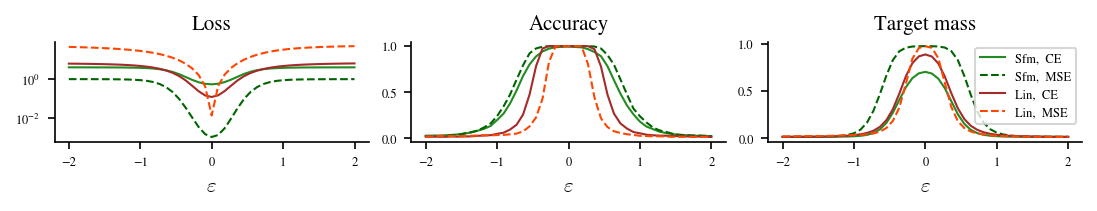

In [10]:
# Settings
titles = ['loss','accuracy','target_mass']
ncols = len(titles)
colors = ['forestgreen','darkgreen','brown','orangered']
setting = dict(lw=1.,marker='',markersize=2,alpha=1.0)


# Plot

fig , axes = create_fig(ncols=ncols,size='double',h=0.18)


for i , tit in enumerate(titles):
    ax = axes[i]
    ax.set_title(tit.capitalize().replace('_',' '))
    ax.set_xlabel(r'$\varepsilon$')
    for j , (attn,loss) in enumerate(configurations):
        lb = 'Sfm' + rf',  {loss.upper()}' if attn=='softmax' else 'Lin' + rf',  {loss.upper()}'
        setting['ls'] = '-' if loss == 'CE' else '--' 
        variable = summary[j][tit]
        ax.plot(epsilons,variable,color=colors[j],label=lb,**setting)

axes[2].legend()
axes[0].set_yscale('log')

names_plot = ['vocab_size','seq_len','lr','num_epochs','alpha','cV','opt','p_error']
params = make_params_dict(names_plot)
save_fig(fig, 'perturbed_loss',params=params,date=True)

# Single index case

In [23]:
from sam.gauss_exp import expectation_gauss_hermite, compute_grid_weigths
import math 
from sam.activations import get_activation

def teacher(z):
    # Heaviside function
    # return torch.heaviside(z,torch.zeros_like(z))
    return get_activation('He4')[0](z)

def student(z):
    # return 1/(1+torch.exp(-z))
    return get_activation('He4')[0](z)

# def sigmoid(z):
#     # Sigmoid function
#     return 1/(1+torch.exp(-z))


def MSE(z1,z2, M, Q, Q_star):
    c = M / math.sqrt(Q_star*Q)
    h_star = math.sqrt(Q_star)*z1
    h = math.sqrt(Q)*(c*z1 + math.sqrt(1 - c**2)*z2)

    return 0.5*(teacher(h_star) - student(h))**2

def MSE_sigm(z1,z2, M, Q, Q_star):
    c = M / math.sqrt(Q_star*Q)
    h_star = math.sqrt(Q_star)*z1
    h = math.sqrt(Q)*(c*z1 + math.sqrt(1 - c**2)*z2)

    return 0.5*(teacher(h_star) - student(h))**2



def CE(z1,z2, M, Q, Q_star):
    c = M / math.sqrt(Q_star*Q)
    h_star = math.sqrt(Q_star)*z1
    h = math.sqrt(Q)*(c*z1 + math.sqrt(1 - c**2)*z2)
    stud = student(h)
    
    return -(teacher(h_star)*torch.log(stud+1e-12) + (1-teacher(h_star))*torch.log(1-stud+1e-12))

In [24]:
grid , weigths = compute_grid_weigths(n=30)

Q_star = 1
Q = 1
M = 1

pop_loss = expectation_gauss_hermite(MSE,Q,Q_star,M,grid,weigths)
print(f'Population loss = {pop_loss}'   )

Population loss = 0.0


In [26]:
Q_star = 1
Qs = [0.5 , 1.0 , 1.5 , 2.0]
loss_fns = {
    'MSE': MSE,
    # 'MSE_sigm': MSE_sigm,
    # 'CE': CE
}

losses = {
    'MSE': {Q:[] for Q in Qs},
    # 'MSE_sigm': {Q:[] for Q in Qs},
    # 'CE': {Q:[] for Q in Qs}
}
for loss_name, loss_fn in loss_fns.items():
    for Q in Qs:
        Ms = np.linspace(0,np.sqrt(Q*Q_star),30)
        for M in Ms:
            pop_loss = expectation_gauss_hermite(loss_fn,Q,Q_star,M,grid,weigths)
            losses[loss_name][Q].append(pop_loss)

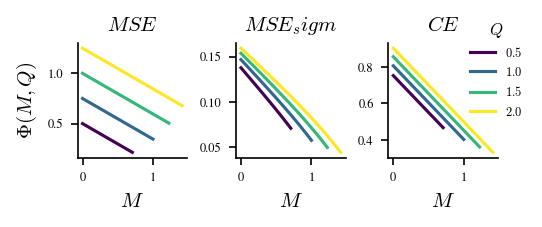

In [273]:
# Settings
colors = plt.get_cmap('viridis')(np.linspace(0,1,len(Qs)))
set_font_sizes(conf='tight')

# Plots
fig , axes = create_fig(ncols=3,h=0.4)

for i , loss_name in enumerate(loss_fns.keys()):
    ax = axes[i]
    ax.set_title(rf'${loss_name}$')
    ax.set_xlabel(r'$M$')
    # ax.set_yscale('log')    
    if i == 0: ax.set_ylabel(r'$\Phi(M,Q)$')
    for Q in Qs:
        phi = losses[loss_name][Q]
        Ms = np.linspace(0,np.sqrt(Q*Q_star),len(phi))
        ax.plot(Ms,phi,label=fr'${Q:.1f}$',color=colors[Qs.index(Q)])
ax.legend(title=r'$Q$',ncols=1,loc=(0.7,0.3),frameon=False)



In [38]:
Q_star = 1.0
rhos = [ 0.8, 0.85, 0.9, 0.95, 1.0 ]
loss_fns = {
    'MSE': MSE,
    # 'Sigm_MSE': MSE_sigm,
    # 'CE': CE
}
Qs = np.linspace(0.0,40,400)[1:]
losses = {
    'MSE': (np.linspace(0.0,2,40)[:], {rho:[] for rho in rhos}),
    # 'Sigm_MSE': (np.linspace(0.0,30,40)[:], {rho:[] for rho in rhos}),
    # 'CE' : (np.linspace(0.0,30,40)[:], {rho:[] for rho in rhos})
}
for loss_name, loss_fn in loss_fns.items():
    Qs = losses[loss_name][0]
    for rho in rhos:
        for Q in Qs:
            M = rho * np.sqrt(Q * Q_star)
            pop_loss = expectation_gauss_hermite(loss_fn,Q,Q_star,M,grid,weigths)
            losses[loss_name][1][rho].append(pop_loss)

Figure saved on /u/c/cerazova/SAM/plots/2026-02 as pop_loss_single_index_model_HE4.png


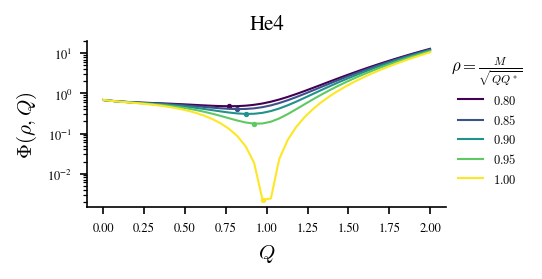

In [41]:
# Settings
colors = plt.get_cmap('viridis')(np.linspace(0,1,len(rhos)))
set_font_sizes(conf='tight')

# xlims = [2,40]
# Plots
fig , axes = create_fig(ncols=1,h=0.5,sharex=False,sharey=False)

for i , loss_name in enumerate(loss_fns.keys()):
    ax = axes
    ax.set_title(f'He4')
    ax.set_xlabel(r'$Q$')
    ax.set_yscale('log')
    # ax.set_xscale('log')
    # if i==0:
        # ax.set_xticks([0.05,0.5],[0.05,0.5])
    # else:
        # ax.set_xticks([3,30],[3,30])



    
    if i == 0: ax.set_ylabel(r'$\Phi(\rho,Q)$')
    for rho in rhos:
        Qs = losses[loss_name][0]
        phi = np.array(losses[loss_name][1][rho])
        
        ax.plot(Qs,phi,label=fr'${rho:.2f}$',color=colors[rhos.index(rho)],lw=1)
        idx = np.argmin(phi)
        ax.scatter(Qs[idx],phi[idx],color=colors[rhos.index(rho)],marker='.',s=10)

ax.legend(title=r'$\rho = \frac{M}{\sqrt{QQ^*}}$',ncols=1,loc=(1.0,0.1),frameon=False)

# names_plot = ['vocab_size','seq_len','lr','num_epochs','alpha','cV','opt','p_error']
# params = make_params_dict(names_plot)
save_fig(fig, 'pop_loss_single_index_model_HE4',params=None,date=True)


In [265]:
np.log(2)
0.5**2

0.25

In [132]:
Q_star = 1.0
Qs = [0.1,0.5 , 1.0 , 1.5]
loss_fns = {
    'MSE': MSE,
    'CE': CE
}
rhos = np.linspace(0.8,1,50)#[1:]
losses = {
    'MSE': {Q:[] for Q in Qs},
    'CE': {Q:[] for Q in Qs}
}

for loss_name, loss_fn in loss_fns.items():
    for Q in Qs:
        for rho in rhos:
            M = rho * np.sqrt(Q * Q_star)
            pop_loss = expectation_gauss_hermite(loss_fn,Q,Q_star,M,grid,weigths)
            losses[loss_name][Q].append(pop_loss)

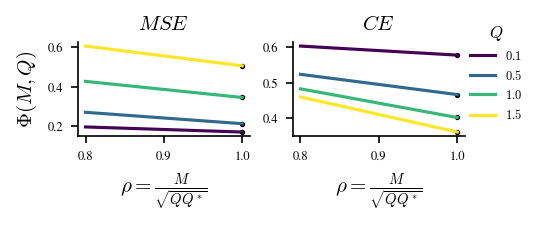

In [134]:
# Settings
colors = plt.get_cmap('viridis')(np.linspace(0,1,len(Qs)))
set_font_sizes(conf='tight')

# Plots
fig , axes = create_fig(ncols=2,h=0.4)

for i , loss_name in enumerate(loss_fns.keys()):
    ax = axes[i]
    ax.set_title(rf'${loss_name}$')
    ax.set_xlabel(r'$\rho = \frac{M}{\sqrt{QQ^*}}$')
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    if i == 0: ax.set_ylabel(r'$\Phi(M,Q)$')
    for i , Q in enumerate(Qs):
        phi = losses[loss_name][Q]
        ax.plot(rhos,phi,label=fr'${Q:.1f}$',color=colors[i])
        idx = np.argmin(phi)
        ax.scatter(rhos[idx],phi[idx],color=colors[i],marker='.',s=10,edgecolor='k')
ax.legend(title=r'$Q$',ncols=1,loc=(1.0,0.1),frameon=False)

# ax.set_yscale('log')


# Finite sampling

In [228]:
def teacher(z):
    # Heaviside function
    return torch.heaviside(z,torch.zeros_like(z))

def student(z):
    return 1/(1+torch.exp(-z))

# def sigmoid(z):
#     # Sigmoid function
#     return 1/(1+torch.exp(-z))


def MSE_sample(w,X,w_star):
    """ Population MSE loss for linear teacher and student with Gaussian inputs.
    w: student weights (d,k1,k2,...)
    X: input data (n,d)
    w_star: teacher weights (d,)
    """
    h_star = X @ w_star # (n,)
    h = torch.einsum('ij,jkl->ikl',X , w) # (n,k1,k2,...)
    target = teacher(h_star)[:,None,None] # (n,)
    prediction = (h) # (n,k1,k2,...)
    mse = 0.5*(target - prediction)**2 # (n,k1,k2,...)
    return mse.mean(axis=0) # (k1,k2,...)



def CE_sample(w,X,w_star):
    """ Population MSE loss for linear teacher and student with Gaussian inputs.
    w: student weights (d,)
    X: input data (n,d)
    w_star: teacher weights (d,)
    """
    h_star = X @ w_star
    h = torch.einsum('ij,jkl->ikl',X , w) # (n,k1,k2,...)
    target = teacher(h_star)[:,None,None] # (n,)
    prediction = student(h) # (n,k1,k2,...)
    ce = -(target*torch.log(prediction+1e-12) + (1-target)*torch.log(1-prediction+1e-12)) # (n,k1,k2,...)
    return ce.mean(axis=0)

In [229]:
d = 200
n = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
w_star = torch.randn(d).to(device)
w_star /= torch.norm(w_star)

w_perp = torch.randn(d).to(device)
# w_perp -= (w_perp @ w_star) * w_star
w_perp /= torch.norm(w_perp)

X = torch.randn(n,d).to(device)


In [235]:
rhos = torch.tensor([0.5,0.8,1.0]).to(device)
Qs = torch.linspace(0., 2, 45).to(device)


w = rhos[None,None,:]* w_star[:,None,None] + torch.sqrt(1-rhos[None,None,:]**2)*w_perp[:,None,None]
# w /= torch.norm(w,dim=0,keepdim=True)
w = torch.sqrt(Qs[None,:,None]) * w

w = w.to(device)

print(w.shape)
mse_sample = MSE_sample(w,X,w_star)
ce_sample = CE_sample(w,X,w_star)
print(mse_sample.shape,ce_sample.shape)

losses = {
    'MSE': mse_sample.cpu().numpy(),
    'CE': ce_sample.cpu().numpy()
}

rhos = rhos.cpu().numpy()
Qs = Qs.cpu().numpy()

# losses['CE']

torch.Size([200, 45, 3])
torch.Size([45, 3]) torch.Size([45, 3])


Text(0.8, 0.92, '$d = 200,\\; n=10000$')

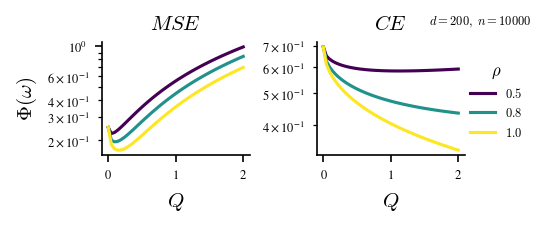

In [236]:
# Settings
colors = plt.get_cmap('viridis')(np.linspace(0,1,len(rhos)))
set_font_sizes(conf='tight')

# Plots
fig , axes = create_fig(ncols=2,h=0.4)

for i , loss_name in enumerate(losses.keys()):
    ax = axes[i]
    ax.set_title(rf'${loss_name}$')
    ax.set_xlabel(r'$Q$')
    ax.set_yscale('log')
    if i == 0: ax.set_ylabel(r'$\Phi(\omega)$')
    for j , rho in enumerate(rhos):
        phi = losses[loss_name][:,j]
        ax.plot(Qs,phi,label=fr'${rho:.1f}$',color=colors[j],alpha=1.0)
        # idx = np.argmin(phi)
        # ax.scatter(Qs[idx],phi[idx],color=colors[rhos.index(rho)],marker='.',s=10,edgecolor='k')
ax.legend(title=r'$\rho$',ncols=1,loc=(1.0,0.1),frameon=False)


# fig.text(0,0.92,r'$\omega = \alpha \omega^* + \varepsilon \omega^\perp$')
fig.text(0.8,0.92,rf'$d = {d},\; n={n}$',size=FONTSIZES['xs'])
# ax.set_yscale('log')



# HE4

In [6]:
# Parameters
d = 50                  # Input dimension
tch_act = 'He4'        # Activation function for teacher
std_act = 'He4'        # Activation function for student
n_test = 8000           # Number of test samples
bs = 1              # Batch size for training
eps = 0.0               # Noise level for labels
q = 2.0                 # q-norm for SAM
lr = 0.00002                # Learning rate
gamma = 0.0
opt = 'SAM'

rhos = [0.0,0.0001,0.001,0.01,0.1][:1]


summary = []

for rho in rhos:
    if rho == 0.0: opt = 'SGD'    
    fix_names = ['d','tch_act','std_act','n_test']
    var_names = ['bs','opt','lr','q','rho','gamma']
    params = make_params_dict(fix_names, var_names)
    summary.append(load_data('first_tests',experiment_name='compare_optimizers', params=params))


step = summary[0]['step']

File first_tests_bs1_gamma0_lr2e-05_optSGD_q2_rho0.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/compare_optimizers/d50_n_test8000_std_actHe4_tch_actHe4


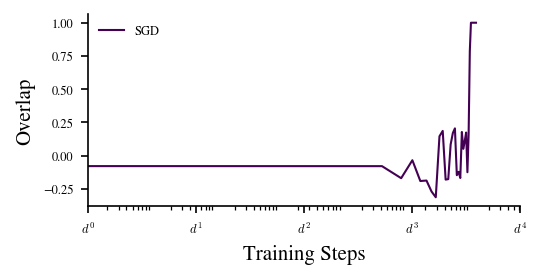

In [17]:
# Settings

set_font_sizes(conf='tight')

x_tk = [d**i for i in range(5)]
x_lb = [f'$d^{i}$' for i in range(5)]

colors = plt.get_cmap('viridis')(np.linspace(0,1,len(rhos)))

# Plot
fig , axes = create_fig()
ax = axes


for i , rho in enumerate(rhos):
    data = summary[i]
    label = rf'$\rho={rho}$' if rho > 0 else 'SGD'
    m = data['overlap']

    axes.plot(data['step'],m*np.sign(m[-1]),label=label,color=colors[i],lw=1)


ax.set_xscale('log')
ax.set_xticks(x_tk,x_lb)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Overlap')
ax.legend(frameon=False)